Streaming data visualization

<IPython.core.display.Javascript object>


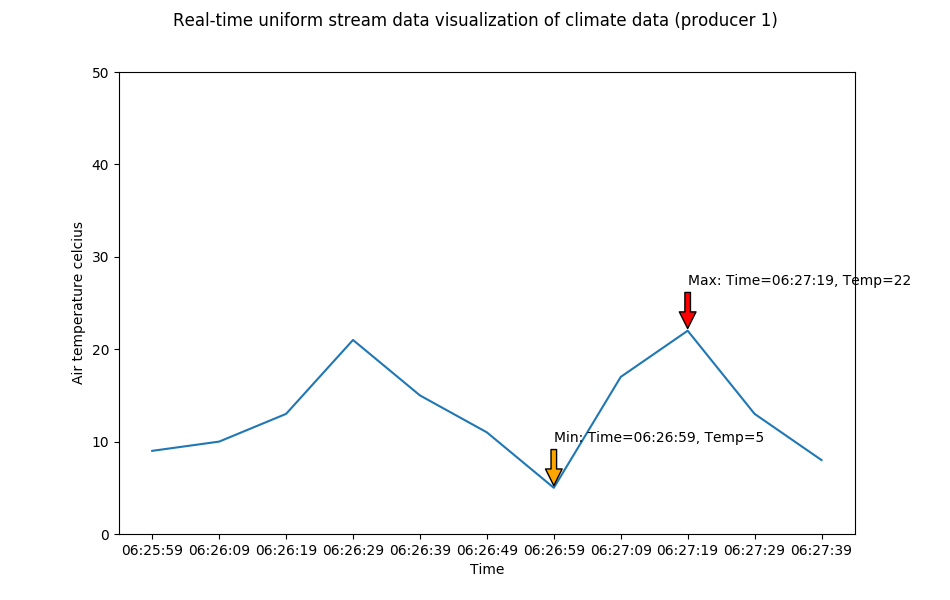

KeyboardInterrupt: 

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import ast
import datetime as dt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'asgn_producer'

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
#                                    consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
#                                    auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Temp={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Temp={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Stream visualization of climate data (Producer 1)') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Air temperature celcius')
        ax.set_ylim(0,50) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex) + " init plot exception")
    
def consume_messages(consumer, fig, ax):
#     try:
        # container for x and y values
    x, y = [], []
#         print('Waiting for messages')
#     min_temp = None
#     max_temp = None
    for message in consumer:
        data = ast.literal_eval(message.value.decode('utf-8')) # Data is a dictionary
        # x is real time and y should be air temperature
        time = str(dt.datetime.now().strftime("%X"))
        air_temp = data.get('air_temperature_celcius')
        if air_temp is not None:
            x.append(time) 
            y.append(data['air_temperature_celcius'])
    #             print(x)
    #             print(y)
#           we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air temperature celcius')
                ax.set_ylim(0,50) 
                ax.set_yticks([0,10,20,30,40,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
    plt.close('all')
#     except Exception as ex:
#         print(str(ex) + " consume message exception")
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

Static data visualization

In [58]:
import pymongo
from pymongo import MongoClient
from pprint import pprint

client = MongoClient()
db = client.asgn_3182
climate_date = db.climate_date
hotspot_col = db.hotspot_col

Q1a. Bar chart on number of fire records per hour

In [65]:
from datetime import datetime
dict1 = {}
cursor = list(hotspot_col.find({}))
for record in cursor:
    reports = record['reports']
    for data in reports:
        datetime_str = data['datetime']
        if datetime_str[11:13] in dict1:
            dict1[datetime_str[11:13]] += 1
        else:
            dict1[datetime_str[11:13]] = 1
dict1

{'00': 161,
 '01': 27,
 '03': 297,
 '04': 1942,
 '05': 84,
 '09': 1,
 '12': 42,
 '13': 62,
 '15': 29,
 '23': 16}

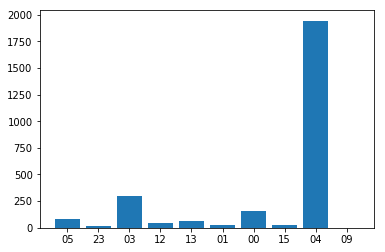

In [68]:
import matplotlib.pyplot as plt
hour = list(dict1.keys())
value = list(dict1.values())

plt.bar(range(len(dict1)), value, tick_label=hour)
plt.show()

Q2b. Folium map visualizer with dummy data

In [126]:
cursor_natural = list(hotspot_col.aggregate([
    {"$unwind": "$reports"},
    {"$lookup": {
        "from":"climate_date",
        "localField":"reports.date",
        "foreignField":"date",
        "as":"merge_date"}
    },
    {"$unwind": "$merge_date"},
    {"$match": {"reports.cause_of_fire": "natural"}}
]))
for record in cursor_natural:
    pprint(record)

{'_id': ObjectId('60aa212e93436977b539bbdd'),
 'latitude': -36.4573,
 'longitude': 142.2323,
 'merge_date': {'GHI_w/m2': 194,
                '_id': ObjectId('60aa212e93436977b539bbdc'),
                'air_temperature_celcius': 24,
                'date': '07-02-2019',
                'max_wind_speed': 9.9,
                'precipitation ': ' 0.00I',
                'relative_humidity': 56.8,
                'windspeed_knots': 5.7},
 'reports': {'cause_of_fire': 'natural',
             'confidence': 88,
             'date': '07-02-2019',
             'datetime': '2019-02-06T09:36:00',
             'surface_temperature_celcius': 63}}


In [125]:
cursor_other = list(hotspot_col.aggregate([
    {"$unwind": "$reports"},
    {"$lookup": {
        "from":"climate_date",
        "localField":"reports.date",
        "foreignField":"date",
        "as":"merge_date"}
    },
    {"$unwind": "$merge_date"},
    {"$match": {"reports.cause_of_fire": "other"}}
]))
for record in cursor_other:
    pprint(record)

{'_id': ObjectId('60aa1f0a934369752e65f0d5'),
 'latitude': -35.9049,
 'longitude': 143.6874,
 'merge_date': {'GHI_w/m2': 136,
                '_id': ObjectId('60aa1f0a934369752e65f0d4'),
                'air_temperature_celcius': 17,
                'date': '03-01-2019',
                'max_wind_speed': 19.0,
                'precipitation ': ' 0.04G',
                'relative_humidity': 58.1,
                'windspeed_knots': 11.7},
 'reports': {'cause_of_fire': 'other',
             'confidence': 81,
             'date': '03-01-2019',
             'datetime': '2019-01-01T19:12:00',
             'surface_temperature_celcius': 54}}
{'_id': ObjectId('60aa1f0a934369752e65f0d5'),
 'latitude': -35.9049,
 'longitude': 143.6874,
 'merge_date': {'GHI_w/m2': 112,
                '_id': ObjectId('60aa1fd29343697690f11c5d'),
                'air_temperature_celcius': 13,
                'date': '03-01-2019',
                'max_wind_speed': 9.9,
                'precipitation ': ' 0.01G',
  

 'reports': {'cause_of_fire': 'other',
             'confidence': 76,
             'date': '11-01-2019',
             'datetime': '2019-01-10T04:48:00',
             'surface_temperature_celcius': 49}}
{'_id': ObjectId('60aa20209343697690f11c77'),
 'latitude': -37.2212,
 'longitude': 148.8262,
 'merge_date': {'GHI_w/m2': 93,
                '_id': ObjectId('60aa20209343697690f11c75'),
                'air_temperature_celcius': 10,
                'date': '11-01-2019',
                'max_wind_speed': 16.9,
                'precipitation ': ' 0.08G',
                'relative_humidity': 39.9,
                'windspeed_knots': 12.6},
 'reports': {'cause_of_fire': 'other',
             'confidence': 76,
             'date': '11-01-2019',
             'datetime': '2019-01-10T04:48:00',
             'surface_temperature_celcius': 49}}
{'_id': ObjectId('60aa205c93436977b539bba2'),
 'latitude': -37.0193,
 'longitude': 148.1459,
 'merge_date': {'GHI_w/m2': 81,
                '_id': ObjectId

In [132]:
import folium

m = folium.Map()

# For natural fire events
for document in cursor_natural:
    lat = document['latitude']
    long = document['longitude']
    air_temp = document['merge_date']['air_temperature_celcius']
    surface_temp = document['reports']['surface_temperature_celcius']
    rel_humid = document['merge_date']['relative_humidity']
    cause_fire = document['reports']['cause_of_fire']
    folium.Marker(
        location=[lat, long],
        icon=folium.Icon(color="blue"),
        tooltip="air temp: " + str(air_temp) + ", surface temp: " + str(surface_temp) + ", relative humid: " + str(rel_humid)
    ).add_to(m)

# For other fire events
for document in cursor_other:
    lat = document['latitude']
    long = document['longitude']
    air_temp = document['merge_date']['air_temperature_celcius']
    surface_temp = document['reports']['surface_temperature_celcius']
    rel_humid = document['merge_date']['relative_humidity']
    cause_fire = document['reports']['cause_of_fire']
    folium.Marker(
        location=[lat, long],
        icon=folium.Icon(color="red"),
        tooltip="air temp: " + str(air_temp) + ", surface temp: " + str(surface_temp) + ", relative humid: " + str(rel_humid)
    ).add_to(m)

In [133]:
m